Fundamentos de ciência de dados - Luiz Davi e Thiago Cavalcanti

In [5]:
from nba_api_jogadores_utils import obter_logs_dos_jogos_por_jogador
from constantes_jogadores import DICIONARIO_JOGADORES, TEMPORADA_ATUAL, RESULTADOS_PATH
import pandas as pd
import numpy as np

# Regressão Linear: variáveis dependentes e independentes 

## RF3 – Possível uso  de variáveis independentes:  tempo que o jogador passou em quadra, arremessos tentados e turnovers. Variáveis dependentes, pontos, assistências e rebotes. Divida os dados de teste e treinamento.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Coletando os dados

In [8]:
lista_de_dataframes = []
for nome, id in DICIONARIO_JOGADORES.items():
    dados = obter_logs_dos_jogos_por_jogador(id, TEMPORADA_ATUAL)
    dados = dados[['GAME_DATE', 'MIN', 'FGA', 'TOV', 'PTS', 'AST', 'REB']]
    dados['PLAYER'] = nome
    lista_de_dataframes.append(dados)

In [9]:
dataframe_nba = pd.concat(lista_de_dataframes)
dataframe_nba.columns = ['Data', 'Minutos', 'Arremessos', 'Turnovers', 'Pontos', 'Assistências', 'Rebotes', 'Jogador']

dataframe_nba.head()

,Data,Minutos,Arremessos,Turnovers,Pontos,Assistências,Rebotes,Jogador
0,"FEB 03, 2025",36,13,1,27,10,14,Nikola Jokić
1,"FEB 01, 2025",37,17,4,28,17,13,Nikola Jokić
2,"JAN 31, 2025",37,16,6,28,13,9,Nikola Jokić
3,"JAN 29, 2025",33,15,2,17,6,6,Nikola Jokić
4,"JAN 27, 2025",40,21,4,33,14,12,Nikola Jokić


Selecionando variáveis independentes e dependentes

In [10]:
X = dataframe_nba[['Minutos', 'Arremessos', 'Turnovers']]
y = dataframe_nba[['Pontos', 'Assistências', 'Rebotes']]

Dividindo os dados em treino e teste (80% treino, 20% teste)

In [11]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

Treinando o modelo e fazendo previsões

In [12]:
modelo = LinearRegression()
modelo.fit(X_treino, y_treino)

y_pred = modelo.predict(X_teste)

### As probabilidades de o jogador marcar acima e abaixo da média, mediana, moda, máximo e mínimo para pontos, rebotes e assistências.

In [13]:
resultados = pd.DataFrame(y_teste, columns=['Pontos', 'Assistências', 'Rebotes'])
resultados['Pontos_previstos'] = y_pred[:, 0]
resultados['Assistências_previstas'] = y_pred[:, 1]
resultados['Rebotes_previstos'] = y_pred[:, 2]

# Calculando estatísticas
estatisticas = resultados.describe()
estatisticas.loc['median'] = resultados.median()
estatisticas.loc['mode'] = resultados.mode().iloc[0]
estatisticas

,Pontos,Assistências,Rebotes,Pontos_previstos,Assistências_previstas,Rebotes_previstos
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,24.964286,6.071429,8.392857,25.000043,6.726763,8.212365
std,10.479193,4.496324,5.814027,9.038627,2.450614,2.020132
min,8.000000,0.000000,2.000000,13.156597,2.150572,5.266981
25%,18.750000,3.000000,4.000000,19.216504,5.197797,7.031884
50%,23.500000,4.500000,6.500000,22.893117,6.085348,7.583015
75%,27.000000,8.250000,12.000000,28.037744,8.641405,9.859067
max,56.000000,16.000000,22.000000,52.618398,12.191091,13.736574
median,23.500000,4.500000,6.500000,22.893117,6.085348,7.583015
mode,22.000000,4.000000,4.000000,15.137151,3.900543,5.835296


In [14]:
dataframe_nba['Acima_media_pontos'] = dataframe_nba['Pontos'] > dataframe_nba['Pontos'].mean()
dataframe_nba['Acima_media_assistências'] = dataframe_nba['Assistências'] > dataframe_nba['Assistências'].mean()
dataframe_nba['Acima_media_rebotes'] = dataframe_nba['Rebotes'] > dataframe_nba['Rebotes'].mean()

# Exibir a proporção de jogos acima da média
dataframe_nba[['Acima_media_pontos', 'Acima_media_assistências', 'Acima_media_rebotes']].mean()

Acima_media_pontos          0.434783
Acima_media_assistências    0.398551
Acima_media_rebotes         0.391304
dtype: float64

## RF4 –  Apresente gráficos que facilitem a interpretação das previsões como matriz de confusão, gráficos de probabilidade predita, curva roc, gráficos de coeficientes, etc. 

In [2]:
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
def exportar_grafico(nome_arquivo):
    caminho_destino = f'{RESULTADOS_PATH}/graficos'
    os.makedirs(caminho_destino, exist_ok=True)

    caminho_arquivo = os.path.join(caminho_destino, nome_arquivo)
    plt.savefig(caminho_arquivo, dpi=300, bbox_inches='tight')

### Matriz de confusão

In [17]:
y_teste_binario = (y_teste > y_teste.mean()).astype(int)
y_pred_binario = (y_pred > np.array(y_teste.mean())).astype(int)

In [42]:
def plotar_matriz_de_confusao(y_teste_binario, y_pred_binario, estatistica_analisada):
    matriz = confusion_matrix(y_teste_binario[estatistica_analisada], y_pred_binario[:, 0])
    sns.heatmap(matriz, annot=True, fmt='d', cmap = 'Greens')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title(f'Matriz de confusão - {estatistica_analisada} acima/abaixo da média')

    exportar_grafico(f'matriz_confusao_{estatistica_analisada}_regressao_linear.png')

    plt.show()

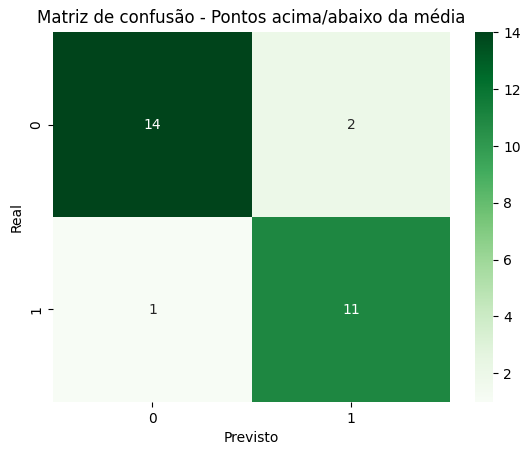

In [43]:
plotar_matriz_de_confusao(y_teste_binario, y_pred_binario[:, [0]], 'Pontos')

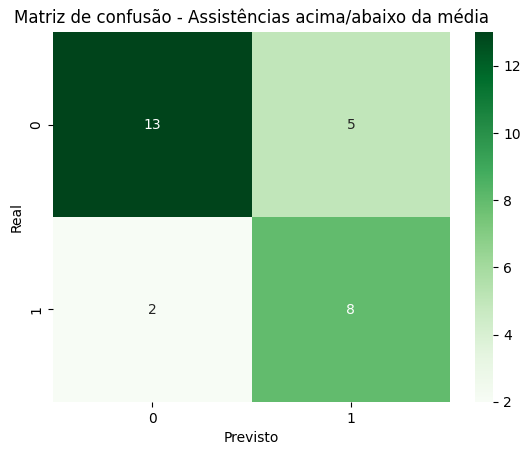

In [44]:
plotar_matriz_de_confusao(y_teste_binario, y_pred_binario[:, [0]], 'Assistências')

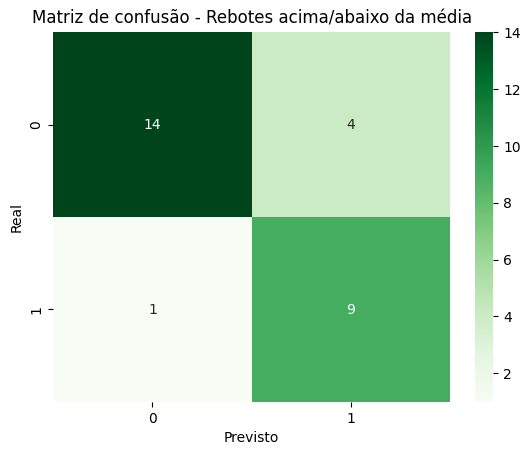

In [45]:
plotar_matriz_de_confusao(y_teste_binario, y_pred_binario[:, [0]], 'Rebotes')

### Gráficos de probabilidade (histogramas de distribuição - real vs previsto)

In [65]:
def plotar_distribuicao(resultados, estatistica_analisada, nome_coluna_previsao):
    sns.histplot(resultados[estatistica_analisada], color='blue', label='Real', kde=True)
    sns.histplot(resultados[nome_coluna_previsao], color='red', label='Previsto', kde=True)
    plt.legend()
    plt.title(f'Distribuição de {estatistica_analisada.lower()}: real vs previsto')

    exportar_grafico(f'probabilidade_{estatistica_analisada}_regressao_linear.png')

    plt.show()

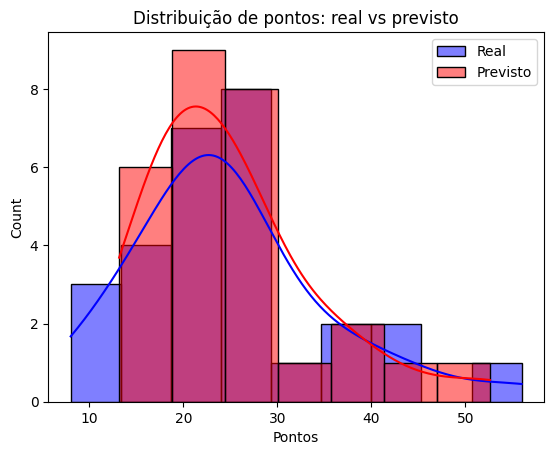

In [66]:
plotar_distribuicao(resultados, 'Pontos', 'Pontos_previstos')

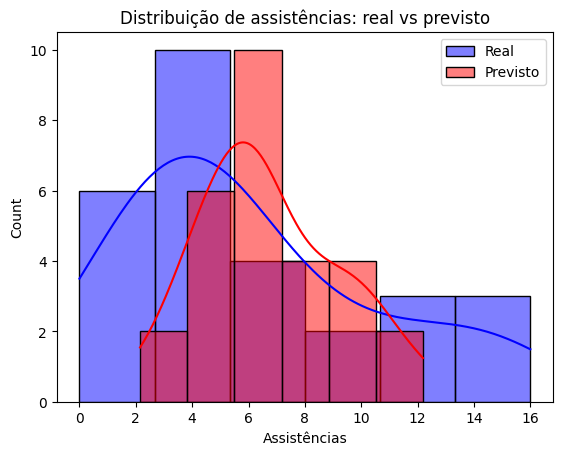

In [68]:
plotar_distribuicao(resultados, 'Assistências', 'Assistências_previstas')

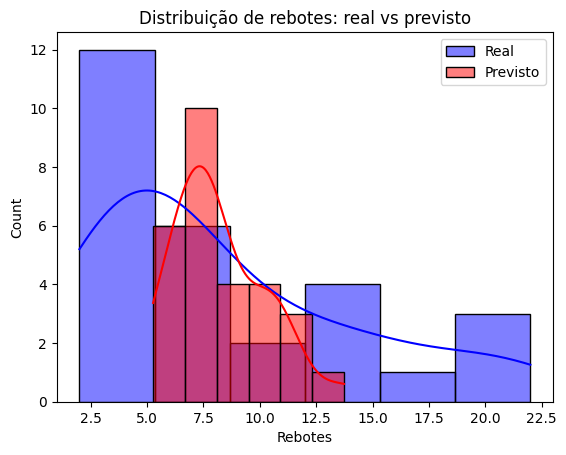

In [67]:
plotar_distribuicao(resultados, 'Rebotes', 'Rebotes_previstos')

### Curva ROC

In [87]:
def plotar_curva_roc(y_teste, y_pred, estatistica_analisada):
    falsos_positivos, verdadeiros_positivos, _ = roc_curve(y_teste[estatistica_analisada], y_pred)
    roc_auc = auc(falsos_positivos, verdadeiros_positivos)
    
    plt.plot(falsos_positivos, verdadeiros_positivos, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdadeiros positivos')
    plt.title(f'Curva ROC - {estatistica_analisada}')
    plt.legend()

    exportar_grafico(f'curva_roc_{estatistica_analisada}_regressao_linear.png')

    plt.show()

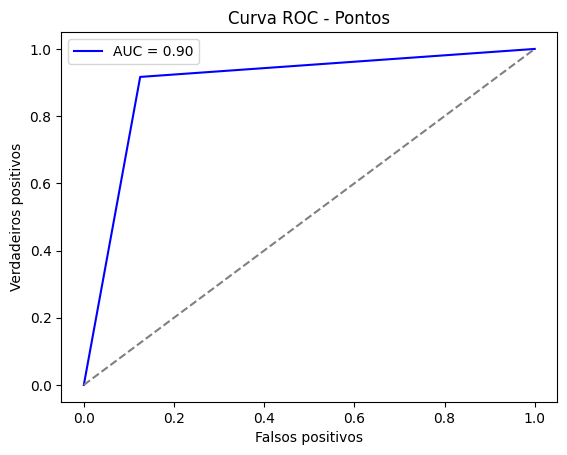

In [88]:
plotar_curva_roc(y_teste_binario, y_pred_binario[:, [0]], 'Pontos')

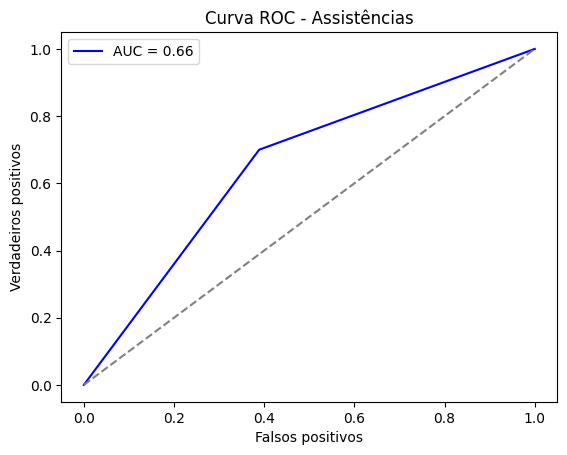

In [89]:
plotar_curva_roc(y_teste_binario, y_pred_binario[:, [1]], 'Assistências')

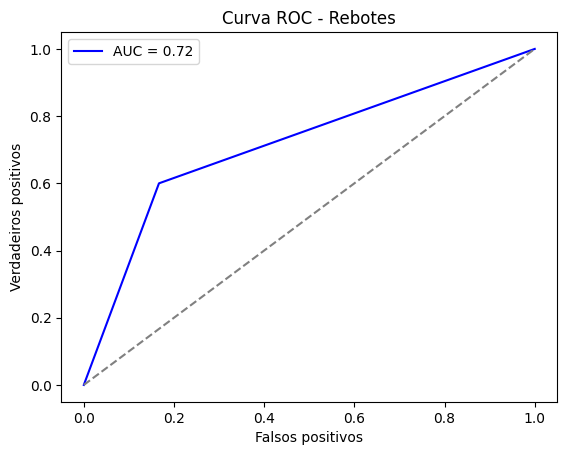

In [90]:
plotar_curva_roc(y_teste_binario, y_pred_binario[:, [2]], 'Rebotes')

### Gráfico de coeficientes

In [91]:
def plotar_grafico_coeficientes():
    dataframe_coeficientes = pd.DataFrame(modelo.coef_, columns=X.columns, index=['Pontos', 'Assistências', 'Rebotes']).T

    dataframe_coeficientes.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.axhline(0, color='black', linewidth=1)
    plt.title("Coeficientes da regressão linear")
    plt.ylabel("Impacto na variável dependente")
    plt.xticks(rotation=0)
    plt.legend(title="Variável dependente")

    exportar_grafico(f'grafico_de_coeficientes_regressao_linear.png')

    plt.show()

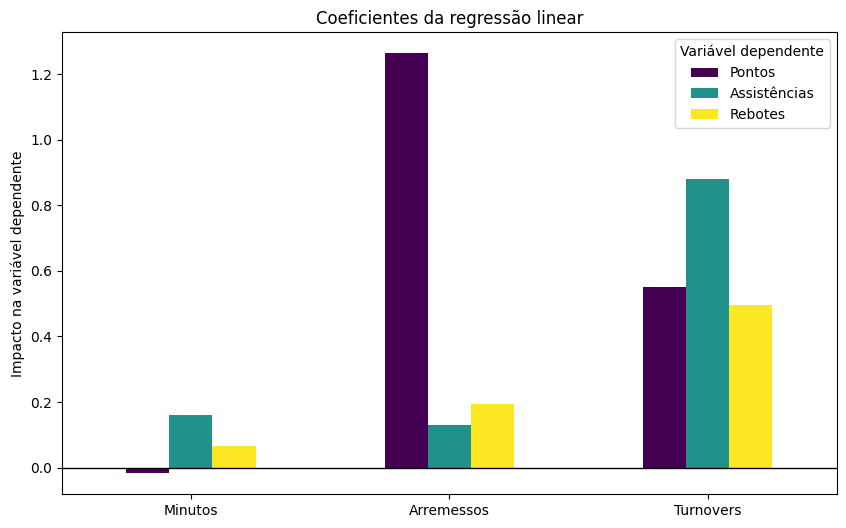

In [92]:
plotar_grafico_coeficientes()

### Matriz de correlação

In [93]:
def plotar_matriz_correlacao():
    matriz_correlacao = dataframe_nba[['Minutos', 'Arremessos', 'Turnovers', 'Pontos', 'Assistências', 'Rebotes']].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Matriz de correlação")

    exportar_grafico(f'matriz_de_correlacao_regressao_linear.png')

    plt.show()

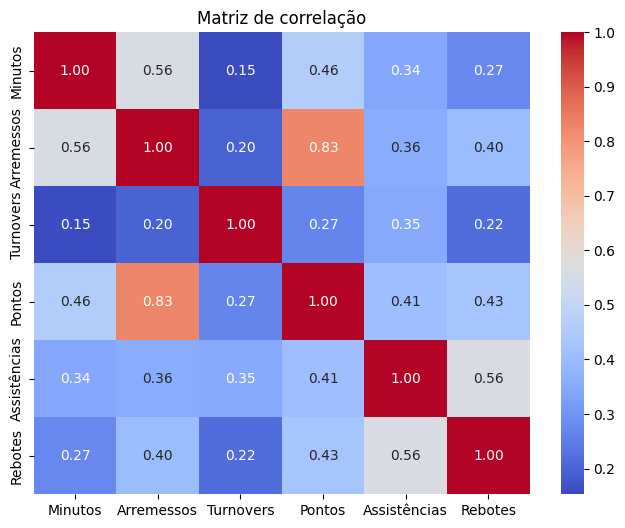

In [94]:
plotar_matriz_correlacao()